### Load Risk Prediction ML Pipeline

### Import packages

In [1]:
import os
import sys
import numpy as np

sys.path.append(os.path.abspath(os.path.join('../')))

In [2]:
from src.utils.data_extractor import DataExtractor
from src.utils.eda_analyzer import EDAAnalyzer
from src.utils.data_preprocessor import DataPreprocessor
from src.utils.model_trainer import LightGBMAutoML

### Step 1: Data Extraction

In [3]:
loan_filepath = "../data/loan.csv"
loan_df = DataExtractor.extract_csv(file_path=loan_filepath)

2024-09-17 23:13:37,437 - INFO - Extracted data from CSV file: ../data/loan.csv


In [4]:
loan_df.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23T17:29:01.940000,False,NaN,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01T13:51:14.709000,False,NaN,0.0,False,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06T23:58:08.880000,False,NaN,0.0,False,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05T22:31:34.304000,False,NaN,0.0,False,0,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1


### Step 2: Data Pre-Processing

In [5]:
loan_df.shape

(577682, 19)

In [6]:
pre_processor = DataPreprocessor(loan_df)
replacements = [
    {
        'column': 'fpStatus',
        'from': np.nan,
        'to': 'NoAchAttempt'
    },
    {
        'column': 'nPaidOff',
        'from': np.nan,
        'to': 0
    }  
    ]

# Create a preprocessing pipeline
X_train, X_test, y_train, y_test =  (
    pre_processor
    .drop_rows_with_nulls_in_columns(columns=['loanId', 'apr', 'loanAmount', 'payFrequency', 'loanStatus'])
    .replace_values(replacements)
    .handle_missing_values(strategy='most_frequent', columns=['state'])
 
    .drop_columns(["loanId", 'applicationDate', 'originatedDate', 'clarityFraudId', 'state'])
    .drop_duplicates()
    .split_data(target_column="loanStatus")
)

   # .handle_outliers(method="iqr")  # Handle outliers using the IQR method
    # .encode_categorical_columns(encoding_type="onehot")
    # .scale_columns(method="standard")

2024-09-17 23:13:38,104 - INFO - Dropped rows with null values in column loanId. Before: (577682, 19), After: (577426, 19)
2024-09-17 23:13:38,357 - INFO - Dropped rows with null values in column apr. Before: (577426, 19), After: (573760, 19)
2024-09-17 23:13:38,618 - INFO - Dropped rows with null values in column loanAmount. Before: (573760, 19), After: (573731, 19)
2024-09-17 23:13:38,929 - INFO - Dropped rows with null values in column payFrequency. Before: (573731, 19), After: (572512, 19)
2024-09-17 23:13:39,199 - INFO - Dropped rows with null values in column loanStatus. Before: (572512, 19), After: (572377, 19)
2024-09-17 23:13:39,200 - INFO - Final shape after dropping rows with null values in columns: ['loanId', 'apr', 'loanAmount', 'payFrequency', 'loanStatus']. Initial shape: (577682, 19), Final shape: (572377, 19)
2024-09-17 23:13:39,281 - INFO - Replaced nan with NoAchAttempt in column: fpStatus
2024-09-17 23:13:39,289 - INFO - Replaced nan with 0 in column: nPaidOff
2024-

In [7]:
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


### Step 3: Model Training

In [8]:
light_gbm = LightGBMAutoML(X_train, X_test, y_train, y_test)

In [9]:
light_gbm.train_model()

2024-09-17 23:13:45,034 - INFO - Starting AutoML training for multi-class classification...


[flaml.automl.logger: 09-17 23:13:50] {1680} INFO - task = classification
[flaml.automl.logger: 09-17 23:13:50] {1691} INFO - Evaluation method: holdout


2024-09-17 23:13:57,630 - INFO - class 4 augmented from 1 to 20
2024-09-17 23:13:59,019 - INFO - class 9 augmented from 4 to 20
2024-09-17 23:14:00,222 - INFO - class 10 augmented from 4 to 20
2024-09-17 23:14:01,976 - INFO - class 12 augmented from 3 to 21
2024-09-17 23:14:04,657 - INFO - class 17 augmented from 2 to 20


[flaml.automl.logger: 09-17 23:14:05] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 09-17 23:14:05] {1901} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 09-17 23:14:05] {2219} INFO - iteration 0, current learner lgbm


2024/09/17 23:14:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: list index out of range


[flaml.automl.logger: 09-17 23:16:55] {2345} INFO - Estimated sufficient time budget=69691063s. Estimated necessary time budget=69691s.
[flaml.automl.logger: 09-17 23:16:55] {2392} INFO -  at 187.2s,	estimator lgbm's best error=0.2209,	best estimator lgbm's best error=0.2209
[flaml.automl.logger: 09-17 23:37:02] {2628} INFO - retrain lgbm for 1207.6s
[flaml.automl.logger: 09-17 23:37:02] {2631} INFO - retrained model: LGBMClassifier(learning_rate=0.09999999999999995, max_bin=255, n_estimators=1,
               n_jobs=-1, num_leaves=4, reg_alpha=0.0009765625, reg_lambda=1.0,
               verbose=-1)
[flaml.automl.logger: 09-17 23:37:02] {1931} INFO - fit succeeded
[flaml.automl.logger: 09-17 23:37:02] {1932} INFO - Time taken to find the best model: 187.24885773658752
run_id: 0b6dd16f275c495ba75da35755601d7b
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
feature_importances: ['feature_importance_gain.json', 'featu

2024/09/17 23:42:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024-09-17 23:42:27,058 - INFO - Best model found: lgbm


#### Evaluate the model

In [10]:
light_gbm.evaluate_model()

/home/babi/miniconda3/envs/moneylion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/babi/miniconda3/envs/moneylion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/babi/miniconda3/envs/moneylion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

(0.8402893321890818,
 '                             precision    recall  f1-score   support\n\n        CSR Voided New Loan       0.00      0.00      0.00       204\n                Charged Off       0.00      0.00      0.00         1\n       Charged Off Paid Off       0.00      0.00      0.00        32\n         Credit Return Void       0.44      1.00      0.61       120\n   Customer Voided New Loan       0.00      0.00      0.00        96\n        External Collection       0.00      0.00      0.00      2246\n        Internal Collection       0.00      0.00      0.00      1114\n                   New Loan       0.44      0.53      0.48      1659\n              Paid Off Loan       0.66      0.05      0.08      2319\n    Pending Application Fee       0.00      0.00      0.00         1\n           Pending Paid Off       0.00      0.00      0.00        22\n            Pending Rescind       0.00      0.00      0.00         1\n                   Rejected       0.92      0.37      0.53     16

In [11]:
loan_df[["loanStatus"]].value_counts(dropna=False)

loanStatus                 
Withdrawn Application          450984
Rejected                        85070
Paid Off Loan                   11427
External Collection             11334
New Loan                         8112
Internal Collection              5567
Returned Item                    1182
CSR Voided New Loan              1026
Settlement Paid Off               708
Credit Return Void                704
Customer Voided New Loan          504
NaN                               391
Settled Bankruptcy                326
Pending Paid Off                  169
Charged Off Paid Off              160
Pending Application Fee             5
Pending Rescind                     4
Pending Application                 4
Voided New Loan                     2
Charged Off                         1
Customver Voided New Loan           1
Settlement Pending Paid Off         1
Name: count, dtype: int64

### Model Evaluation Summary

#### 1. **Accuracy**
- The model achieved an overall accuracy of **83.91%**, meaning it correctly predicted 84% of the test data.

#### 2. **Class-Level Performance**
- Many smaller classes (e.g., **CSR Voided New Loan, Charged Off Paid Off**) had **0.00 precision, recall, and F1-scores**, indicating the model struggled to predict them, likely due to class imbalance.
- **Credit Return Void**: High recall (0.99) but moderate precision (0.48), indicating the model correctly identifies most instances but includes some incorrect predictions.
- **Rejected**: High precision (0.92) but low recall (0.37), meaning the model correctly predicts this class but misses many actual instances.
- **Withdrawn Application**: Strong performance with **precision (0.85)** and **recall (0.99)**, indicating the model handles this class well.

#### 3. **Averages**
- **Macro average** (unweighted) shows low performance across classes, with an F1-score of **0.16**.
- **Weighted average** (considering class sizes) is much better, with an F1-score of **0.80**, indicating strong performance for dominant classes but poor performance for minority classes.

#### 4. **Conclusion**
The model performs well for large classes but struggles with smaller, underrepresented ones. Addressing class imbalance via resampling or class weighting could improve results.

#### Plot feature importance

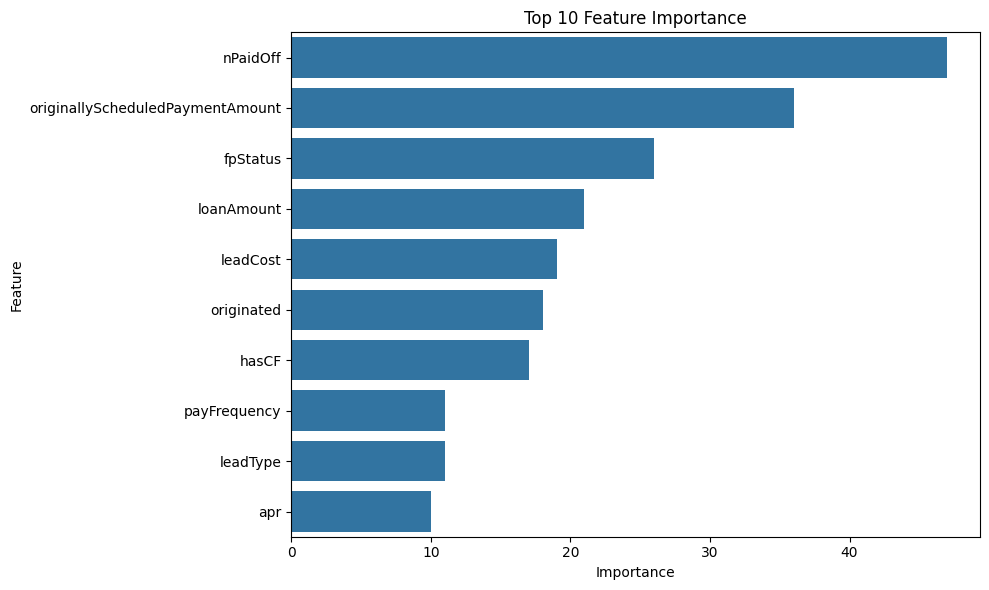

In [12]:
light_gbm.plot_feature_importance()

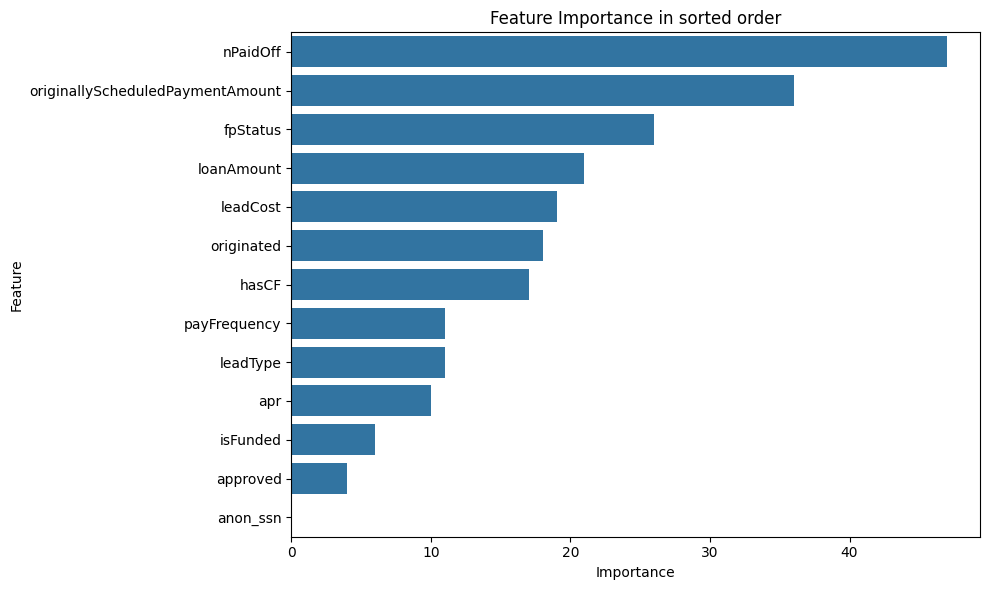

In [13]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


feature_importance = light_gbm.model.feature_importances_
feature_names = light_gbm.X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in sorted order')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [16]:
X_test.dtypes

anon_ssn                            category
payFrequency                        category
apr                                  float64
originated                              bool
nPaidOff                             float64
approved                                bool
isFunded                               int64
loanAmount                           float64
originallyScheduledPaymentAmount     float64
leadType                            category
leadCost                               int64
fpStatus                            category
hasCF                                  int64
dtype: object

#### Plot training metrics

In [17]:
model = light_gbm.model.model

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

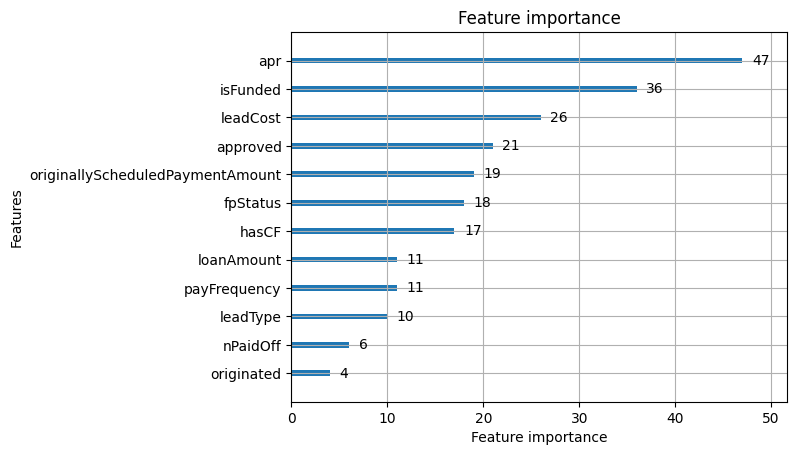

In [18]:
import lightgbm as lgb
lgb.plot_importance(model)

<Figure size 2000x1000 with 0 Axes>

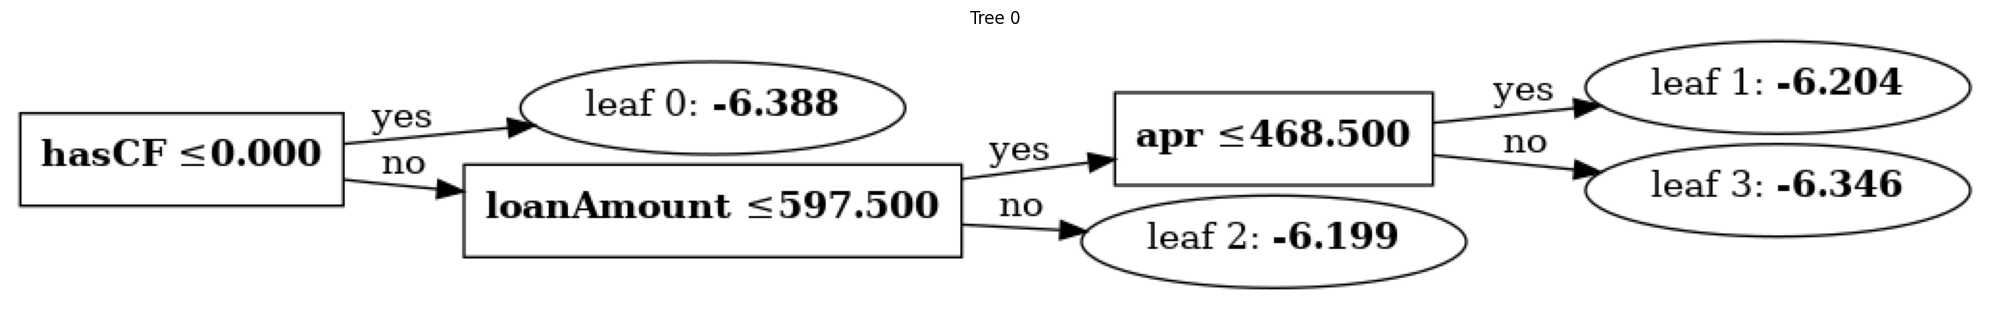

In [23]:
light_gbm.plot_trees(tree_index=0)

<Figure size 2000x1000 with 0 Axes>

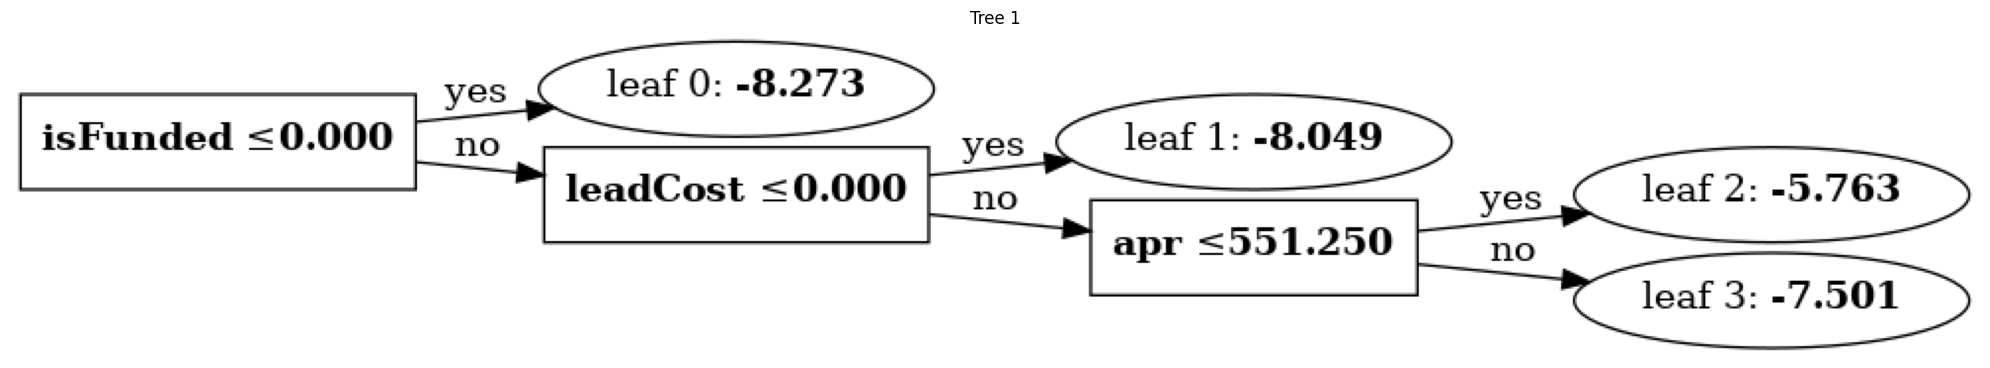

In [26]:
light_gbm.plot_trees(tree_index=1)

In [27]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

import lightgbm as lgb

try:
    from ipywidgets import interact

    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False
    
def render_histogram(feature):
    lgb.plot_split_value_histogram(model, feature=feature, bins="auto", figsize=(10, 5))
    plt.show()


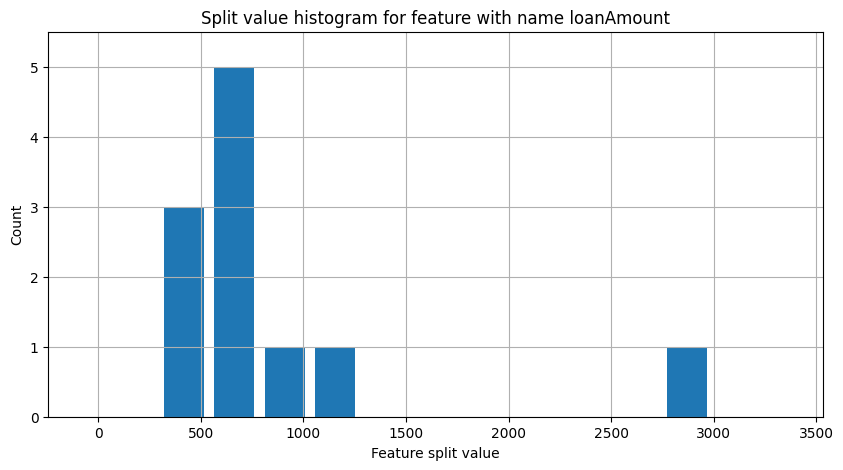

In [28]:
if INTERACTIVE:
    interact(render_histogram, feature=model.feature_name_)
else:
    render_histogram(feature="loanAmount")

In [30]:
from mlflow.models.signature import infer_signature
signature = infer_signature(light_gbm.X_test.iloc[:1] , light_gbm.automl.predict(light_gbm.X_test.iloc[:1]))
light_gbm.automl.predict(light_gbm.X_test.iloc[:1])

/home/babi/miniconda3/envs/moneylion/lib/python3.8/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


array(['Withdrawn Application'], dtype=object)

In [31]:
import mlflow.pyfunc
import subprocess
import mlflow
from mlflow.models.signature import infer_signature


with mlflow.start_run() as run:
        input_example = light_gbm.X_test.iloc[:1]
        signature = infer_signature(light_gbm.X_test.iloc[:1] , light_gbm.automl.predict(input_example))
        mlflow.lightgbm.log_model(light_gbm.automl.model, "hola_temosa", signature=signature, input_example=input_example)
        

/home/babi/miniconda3/envs/moneylion/lib/python3.8/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/09/18 00:00:24 WARNING mlflow.utils.requirements_utils: Failed to run predict on input_example, dependencies introduced in predict are not captured.
ValueError('train and valid dataset categorical_feature do not match.

In [34]:
def serve_model(model_path, port=8001):
    """
    Serve a logged MLflow model using the MLflow serve command.
    :param model_path: The path to the model artifact.
    :param port: The port to serve the model on.
    """
    # Serve the model using mlflow's CLI command
    subprocess.run(["mlflow", "models", "serve", "-m", model_path, "-p", str(port), "--no-conda"])

# Example usage


In [36]:
# run_id = run.info.run_id  # Get the run ID from the logged model

# serve_model(run_id)

model_path = "./mlruns/0/" + 'fb6e6d59f06d4cf987644ad5ce4f25eb' + "/artifacts/model"  # Construct the model path
serve_model(model_path)


2024/09/18 00:01:38 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2024/09/18 00:01:38 INFO mlflow.pyfunc.backend: === Running command 'exec gunicorn --timeout=60 -b 127.0.0.1:8001 -w 1 ${GUNICORN_CMD_ARGS} -- mlflow.pyfunc.scoring_server.wsgi:app'
[2024-09-18 00:01:38 +0300] [731136] [INFO] Starting gunicorn 23.0.0
[2024-09-18 00:01:38 +0300] [731136] [INFO] Listening at: http://127.0.0.1:8001 (731136)
[2024-09-18 00:01:38 +0300] [731136] [INFO] Using worker: sync
[2024-09-18 00:01:38 +0300] [731138] [INFO] Booting worker with pid: 731138
